# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

Classification because the output is a label and are discrete. 

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print("Student data read successfully!")
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
student_dimensions = student_data.shape
n_students = student_dimensions[0]
n_features = student_dimensions[1] - 1 # student data has grad info in last column. (below removes it)
n_passed = 1
n_failed = 1
grad_rate = n_passed / n_students
print("Total number of students: {}".format(n_students))
print("Number of students who passed: {}".format(n_passed))
print("Number of students who failed: {}".format(n_failed))
print("Number of features: {}".format(n_features))
print("Graduation rate of the class: {:.2f}%".format(grad_rate))

Total number of students: 395
Number of students who passed: 1
Number of students who failed: 1
Number of features: 30
Graduation rate of the class: 0.00%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print("Feature column(s):-\n{}".format(feature_cols))
print("Target column: {}".format(target_col))

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print("\nFeature values:-")
print(X_all.head())  # print the first 5 rows
print(y_all.head())

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [148]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all_new = preprocess_features(X_all)
y_all_new = y_all.replace(['yes', 'no'], [1,0])

print("Processed feature columns ({}):-\n{}".format(len(X_all_new.columns), list(X_all_new.columns)))


Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [32]:
from sklearn import cross_validation
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all_new, y_all_new, test_size=num_test, random_state=0)

# Note: If you need a validation set, extract it from within training data
# Grabbing 50 for validation-set
X_train, X_validation, y_train, y_validation = cross_validation.train_test_split(X_train, y_train, test_size=50, random_state=0)

print("Training set: {} samples".format(X_train.shape[0]))
print("Validation set: {} samples".format(X_validation.shape[0]))
print("Test set: {} samples".format(X_test.shape[0]))

Training set: 250 samples
Validation set: 50 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [81]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    # print("Training {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    # print("Done!\nTraining time (secs): {:.3f}".format(end - start))
    return end - start

# TODO: Choose a model, import it and instantiate an object
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor()

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
print(clf)  # you can inspect the learned model by printing it

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')


In [82]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    # print("Predicting labels using {}...".format(clf.__class__.__name__))
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    # print("Done!\nPrediction time (secs): {:.3f}".format(end - start))
    return f1_score(target.values, y_pred, pos_label=1), end - start

train_f1_score = predict_labels(clf, X_train, y_train)
print("F1 score for training set: {}".format(train_f1_score))

F1 score for training set: (1.0, 0.0004050731658935547)


In [83]:
# Predict on test data
print("F1 score for test set: {}".format(predict_labels(clf, X_test, y_test)))

F1 score for test set: (0.69841269841269848, 0.0004119873046875)


In [223]:
# Train and predict using different training set sizes
import numpy as np
import pandas as pd
from sklearn import linear_model, svm, neighbors, gaussian_process, ensemble, calibration

def train_predict(clf, X_train, y_train, X_test, y_test):
    # print("------------------------------------------")
    test_size = len(X_train)
    # print("Training set size: {}".format(test_size))
    train_time = train_classifier(clf, X_train, y_train)
    f1_train, predict_time_train = predict_labels(clf, X_train, y_train)
    f1_test, predict_time_test = predict_labels(clf, X_test, y_test)
    # print("F1 score for training set: {}".format(f1_train))
    # print("F1 score for test set: {}".format(f1_test))
    return { 
        'f1_train': f1_train, 
        'f1_test': f1_test, 
        'test_size': test_size,
        'clf_name': clf.__class__.__name__,
        'train_time': train_time,
        'predict_time_train': predict_time_train,
        'predict_time_test': predict_time_test
    }
    
# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
training_sizes = [100, 200, 250]
results = []

# define CLFS
logistic_regression_clf_default = linear_model.LogisticRegression()
decision_tree_clf_default = DecisionTreeRegressor()
svm_clf_default = svm.SVC()
gradient_boot_clf_default = ensemble.GradientBoostingClassifier()
knn_clf_default = neighbors.KNeighborsClassifier()
ada_boost_clf_default = ensemble.AdaBoostClassifier()
sdg_clf_default = linear_model.SGDClassifier()
calibrated_clf_default = calibration.CalibratedClassifierCV()

clfs = [
    logistic_regression_clf_default,
    decision_tree_clf_default,
    svm_clf_default,
    knn_clf_default,
    gradient_boot_clf_default,
    ada_boost_clf_default,
    sdg_clf_default,
    calibrated_clf_default
]


for clf in clfs:
    for test_size in training_sizes:
        results.append(train_predict(clf, X_train[:test_size], y_train[:test_size], X_test, y_test))
    
results_table = pd.DataFrame(results)
print(results_table.sort_values('f1_test'))

                      clf_name   f1_test  f1_train  predict_time_test  \
4        DecisionTreeRegressor  0.655738  1.000000           0.000207   
5        DecisionTreeRegressor  0.703125  1.000000           0.000301   
12  GradientBoostingClassifier  0.712121  1.000000           0.000717   
10        KNeighborsClassifier  0.717557  0.844595           0.001336   
3        DecisionTreeRegressor  0.722689  1.000000           0.000172   
15          AdaBoostClassifier  0.728682  0.992481           0.004271   
9         KNeighborsClassifier  0.739130  0.839161           0.001483   
11        KNeighborsClassifier  0.755556  0.869110           0.001767   
7                          SVC  0.761905  0.881029           0.001009   
8                          SVC  0.761905  0.882793           0.001574   
6                          SVC  0.763158  0.857143           0.001074   
18               SGDClassifier  0.766234  0.795181           0.000129   
23      CalibratedClassifierCV  0.766234  0.829040 

In [209]:
# making helper method for clf testing on training-size
def run_analysis(clf):
    #results = []
    result = train_predict(clf, X_train, y_train, X_test, y_test)
    #results.append(result)
    #results_table = pd.DataFrame(results)
    #print(results_table.sort_values('f1_test'))
    return result
    
print('run-analysis loaded...')

run-analysis loaded...


## Models explained:

I choose a more than three here but will dig into three in depth. One note is that 250 was choosen in order to save 50 for final validation once all classifications have been explored. The above allowed classification (couldn't get NN working when writing) so I decided to just to a quick head-to-head comparison and see what happened. I am not surprised that the 'boosted'/'ensemble' methods generally did better. 

I found it interesting that in general DT < KNN < SVM < LogR for the methods that I have the best understanding of. I wonder if seeing the score and how these models react to different data sets we can draw an inference as to some attributes in the data. For example because KNN > DT does that mean that some outliers are having some effect?

#### Decision Tree Regressor
- What is the theoretical O(n) time & space complexity in terms of input size?
    * N^2 * Log(N) from http://scikit-learn.org/stable/modules/tree.html#complexity sk-learn does some optimizations and as you can see in the above table neither the learning or the predictions fall that high compared to the rest.
- What are the general applications of this model? What are its strengths and weaknesses?
    * The primary weaknesses of DT is they tend to overfit. It is very important to get the right ratio of samples to features to try and avoid this. However one very nice feature is that DT tend to give a lot of insights into the important features in the data set and can easily be explained as to how they work. In general this can be used for classification in this case.
- Given what you know about the data so far, why did you choose this model to apply?
    * I chose this model as a simple implementation, to explore the data, and to create a baseline. I had a feeling other models would perform better from an f1-score perspective but believe there is elegance in the simplicity of the DT algorithim and it can be used to explore features and patterns in a mathematically rigerous way (I frequently find myself running other models again and again trying to figure out what is influencing the various parts) See exploration near the bottom for graph showing the tree.
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.
    * The results can be seen above for comparison to other models, below for individual table.

In [212]:
run_analysis(decision_tree_clf_default)

{'clf_name': 'DecisionTreeRegressor',
 'f1_test': 0.68292682926829273,
 'f1_train': 1.0,
 'predict_time_test': 0.00018405914306640625,
 'predict_time_train': 0.0003058910369873047,
 'test_size': 250,
 'train_time': 0.002138853073120117}

#### Logistical Classification
- What is the theoretical O(n) time & space complexity in terms of input size?
    * O(k^2*(n + k)) (from stackoverflow: https://stackoverflow.com/questions/1955088/what-is-the-bigo-of-linear-regression)
    * You can see in the table print out that in general this is one of the faster algorothims when it comes to predictions but training takes time simply because of the matrix multiplication.
    
- What are the general applications of this model? What are its strengths and weaknesses?
    * The logistical regression model is fairly straight forward in understanding and isn't a black box in terms of results. As a general classifier the logistical regression excels with fewer inputs and lots of training data. It can succumb to overfitting and in this particular case it looks like that did happen. I would not use this model in this particular case.
    
- Given what you know about the data so far, why did you choose this model to apply?
    * I felt like this model could have been one of the higher performing models but was worried about the ratio of number of features and training data and that it might lead to some overfitting.
    
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.
    * The results can be seen above, below for individual results.

In [221]:
run_analysis(logistic_regression_clf_default)

{'clf_name': 'LogisticRegression',
 'f1_test': 0.76811594202898548,
 'f1_train': 0.85567010309278357,
 'predict_time_test': 0.000286102294921875,
 'predict_time_train': 0.0016300678253173828,
 'test_size': 250,
 'train_time': 0.021898984909057617}

#### Ada Boost Classifier
- What is the theoretical O(n) time & space complexity in terms of input size?
    * I am actually not sure what the O(n) of Ada would be. O(n^3) You can see that within the training data that this was a magnitude slower than the rest of the training. This makes sense as it is a boosting strategy.
- What are the general applications of this model? What are its strengths and weaknesses?
    * This particular classifier handles the curse of demensionality much better than other models. However, it is not very computationally effective. 
- Given what you know about the data so far, why did you choose this model to apply?
    * Given the small sample size and large feature set (esp. after feature expansion) would make me pick AdaBoost. 
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.
    * The results can be seen above for comparing with other models and below for the 250 results.

In [213]:
run_analysis(ada_boost_clf_default)

{'clf_name': 'AdaBoostClassifier',
 'f1_test': 0.77941176470588225,
 'f1_train': 0.87301587301587302,
 'predict_time_test': 0.003991127014160156,
 'predict_time_train': 0.006087064743041992,
 'test_size': 250,
 'train_time': 0.07855486869812012}

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

1. I am picking the AdaBoostClassifier. The AdaBoost classification system relies on simple decision matrixes (ie. if x then a, if y and z then b) that are in and of themselves machine learning algorthims called Decision trees. These decision trees are kept very simple but the power of the AdaBoost classification system is that it allows them to 'vote' giving the tree with the highest accuracy the most weight as it learns it's input. This has many advantages and in our case returns an f1-score between .779 and .8 depending on the sample size. One of the advantages is not only it's high f1 score but also it's resistence to overfitting. This means that as we continue to impove our collection of student data we do not risk seriously lowering our accuracy. 
    
    <p>There are minor downsides that given this example I do not see us needing to worry about such as high compute time. Given the relatively low amount of data, the frequency at which these predictions would need to be run and how cheap compute power is the justification for the strengths above more than justify this. I think the AdaBoost classification system will be a good pick going forward.</p>
       
2. Did that above explaining to the board. This is one of the strengths of the AdaBoost, while it is an ensable method it is very easy to explain!

3. Below (explanations inline)

4. I found an f1 score of .78 on test data but the final validation data returned: .73

In [234]:
results = []
# exploring trade-off between learning rate and n-estimators
for n in [1,5,10,25,50,100,200,500]:
    for learning_rate in [0.5,1,2]:
        #print('n:', n, ': lr', learning_rate)
        r = run_analysis(ensemble.AdaBoostClassifier(n_estimators=n,learning_rate=learning_rate))
        r['n'] = n
        r['lr'] = learning_rate
        results.append(r)

results_table = pd.DataFrame(results)
print(results_table.sort_values('f1_test'))

              clf_name   f1_test  f1_train   lr    n  predict_time_test  \
23  AdaBoostClassifier  0.105263  0.206897  2.0  500           0.070799   
20  AdaBoostClassifier  0.105263  0.206897  2.0  200           0.025027   
14  AdaBoostClassifier  0.105263  0.206897  2.0   50           0.003903   
8   AdaBoostClassifier  0.105263  0.206897  2.0   10           0.000932   
17  AdaBoostClassifier  0.105263  0.206897  2.0  100           0.008842   
15  AdaBoostClassifier  0.744526  0.892388  0.5  100           0.009729   
21  AdaBoostClassifier  0.746269  0.905149  0.5  500           0.078886   
22  AdaBoostClassifier  0.748092  0.905556  1.0  500           0.058222   
10  AdaBoostClassifier  0.757143  0.870712  1.0   25           0.002402   
19  AdaBoostClassifier  0.757576  0.899183  1.0  200           0.028214   
18  AdaBoostClassifier  0.761194  0.890080  0.5  200           0.016044   
12  AdaBoostClassifier  0.765957  0.875648  0.5   50           0.005643   
16  AdaBoostClassifier  0

In [230]:
print(results_table.sort_values('n'))

              clf_name   f1_test  f1_train   lr    n  predict_time_test  \
0   AdaBoostClassifier  0.802920  0.822581  0.5    1           0.000261   
1   AdaBoostClassifier  0.802920  0.822581  1.0    1           0.000271   
2   AdaBoostClassifier  0.802920  0.822581  2.0    1           0.000263   
3   AdaBoostClassifier  0.802721  0.846535  0.5    5           0.000839   
4   AdaBoostClassifier  0.785714  0.849741  1.0    5           0.000599   
5   AdaBoostClassifier  0.802920  0.822581  2.0    5           0.001210   
6   AdaBoostClassifier  0.791667  0.852792  0.5   10           0.001378   
7   AdaBoostClassifier  0.788732  0.841026  1.0   10           0.001480   
8   AdaBoostClassifier  0.105263  0.206897  2.0   10           0.000951   
10  AdaBoostClassifier  0.757143  0.870712  1.0   25           0.002061   
11  AdaBoostClassifier  0.802920  0.822581  2.0   25           0.003602   
9   AdaBoostClassifier  0.774648  0.866667  0.5   25           0.002045   
12  AdaBoostClassifier  0

In [235]:
print(results_table.sort_values('lr'))

              clf_name   f1_test  f1_train   lr    n  predict_time_test  \
0   AdaBoostClassifier  0.802920  0.822581  0.5    1           0.000280   
18  AdaBoostClassifier  0.761194  0.890080  0.5  200           0.016044   
21  AdaBoostClassifier  0.746269  0.905149  0.5  500           0.078886   
3   AdaBoostClassifier  0.802721  0.846535  0.5    5           0.000968   
12  AdaBoostClassifier  0.765957  0.875648  0.5   50           0.005643   
6   AdaBoostClassifier  0.791667  0.852792  0.5   10           0.002007   
15  AdaBoostClassifier  0.744526  0.892388  0.5  100           0.009729   
9   AdaBoostClassifier  0.774648  0.866667  0.5   25           0.002045   
13  AdaBoostClassifier  0.779412  0.873016  1.0   50           0.003904   
22  AdaBoostClassifier  0.748092  0.905556  1.0  500           0.058222   
19  AdaBoostClassifier  0.757576  0.899183  1.0  200           0.028214   
7   AdaBoostClassifier  0.788732  0.841026  1.0   10           0.001007   
4   AdaBoostClassifier  0

##### Learning Rate & N-Estimators Conclusion:
* We have enough samples that we can keep the learning rate small. The default appears to work just fine. A learning rate of 2 has a significant negative impact.
* N-Estimators. A little worried here because N=1 was most resitent to all the other inputs but N=50 looks most promising (which also happens to be the default).

#### different algos

Below I explored the different algos. The default 'SAMME.R' wins in accuracy but inline with the docummention suggestions SAMME does train slightly faster.

In [141]:
# exploring algo differences
for algo in ['SAMME.R', 'SAMME']:
    print('Algo:', algo)
    run_analysis(ensemble.AdaBoostClassifier(n_estimators=50,learning_rate=1, algorithm=algo))
# look at that.. default wins again.

Algo: SAMME.R
             clf_name   f1_test  test_size  train_time
0  AdaBoostClassifier  0.728682        100    0.055954
2  AdaBoostClassifier  0.779412        250    0.076388
1  AdaBoostClassifier  0.800000        200    0.063052
Algo: SAMME
             clf_name   f1_test  test_size  train_time
1  AdaBoostClassifier  0.751880        200    0.054628
0  AdaBoostClassifier  0.755556        100    0.050263
2  AdaBoostClassifier  0.774648        250    0.050808


In [246]:
# using the final validation 50
# nervious, only can run this once!
clf = train_predict(ensemble.AdaBoostClassifier(n_estimators=50,learning_rate=1), X_train, y_train, X_validation, y_validation)
print(clf['f1_test'])


0.735294117647


## Extra Exploration:

I wanted to play with a couple other models, here that work is...

In [169]:
# exploring knn more. curious.
# for leaf_size in [1,5,10,30,60,100,200]:
# don't see a big difference changing leaf-size
    #n = 10
# for n in [1,5,10,30,60,90]:
# n = 10 looks like the best (78 vs most 76, n=1=>69..)
    #weight = 'distance'
for weight in ['uniform', 'distance']:
    leaf_size=30 # default
    n = 10 # best so far.
    print("LS:", leaf_size, " n: ", n, " weight: ", weight)
    run_analysis(neighbors.KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n, weights=weight))

# uniform is slightly higher in all examples except low-sample size. 

LS: 30  n:  10  weight:  uniform
               clf_name   f1_test  test_size  train_time
0  KNeighborsClassifier  0.711111        100    0.000755
1  KNeighborsClassifier  0.744526        200    0.000681
2  KNeighborsClassifier  0.788732        250    0.001086
LS: 30  n:  10  weight:  distance
               clf_name   f1_test  test_size  train_time
0  KNeighborsClassifier  0.727273        100    0.000936
1  KNeighborsClassifier  0.746479        200    0.001215
2  KNeighborsClassifier  0.783217        250    0.000838


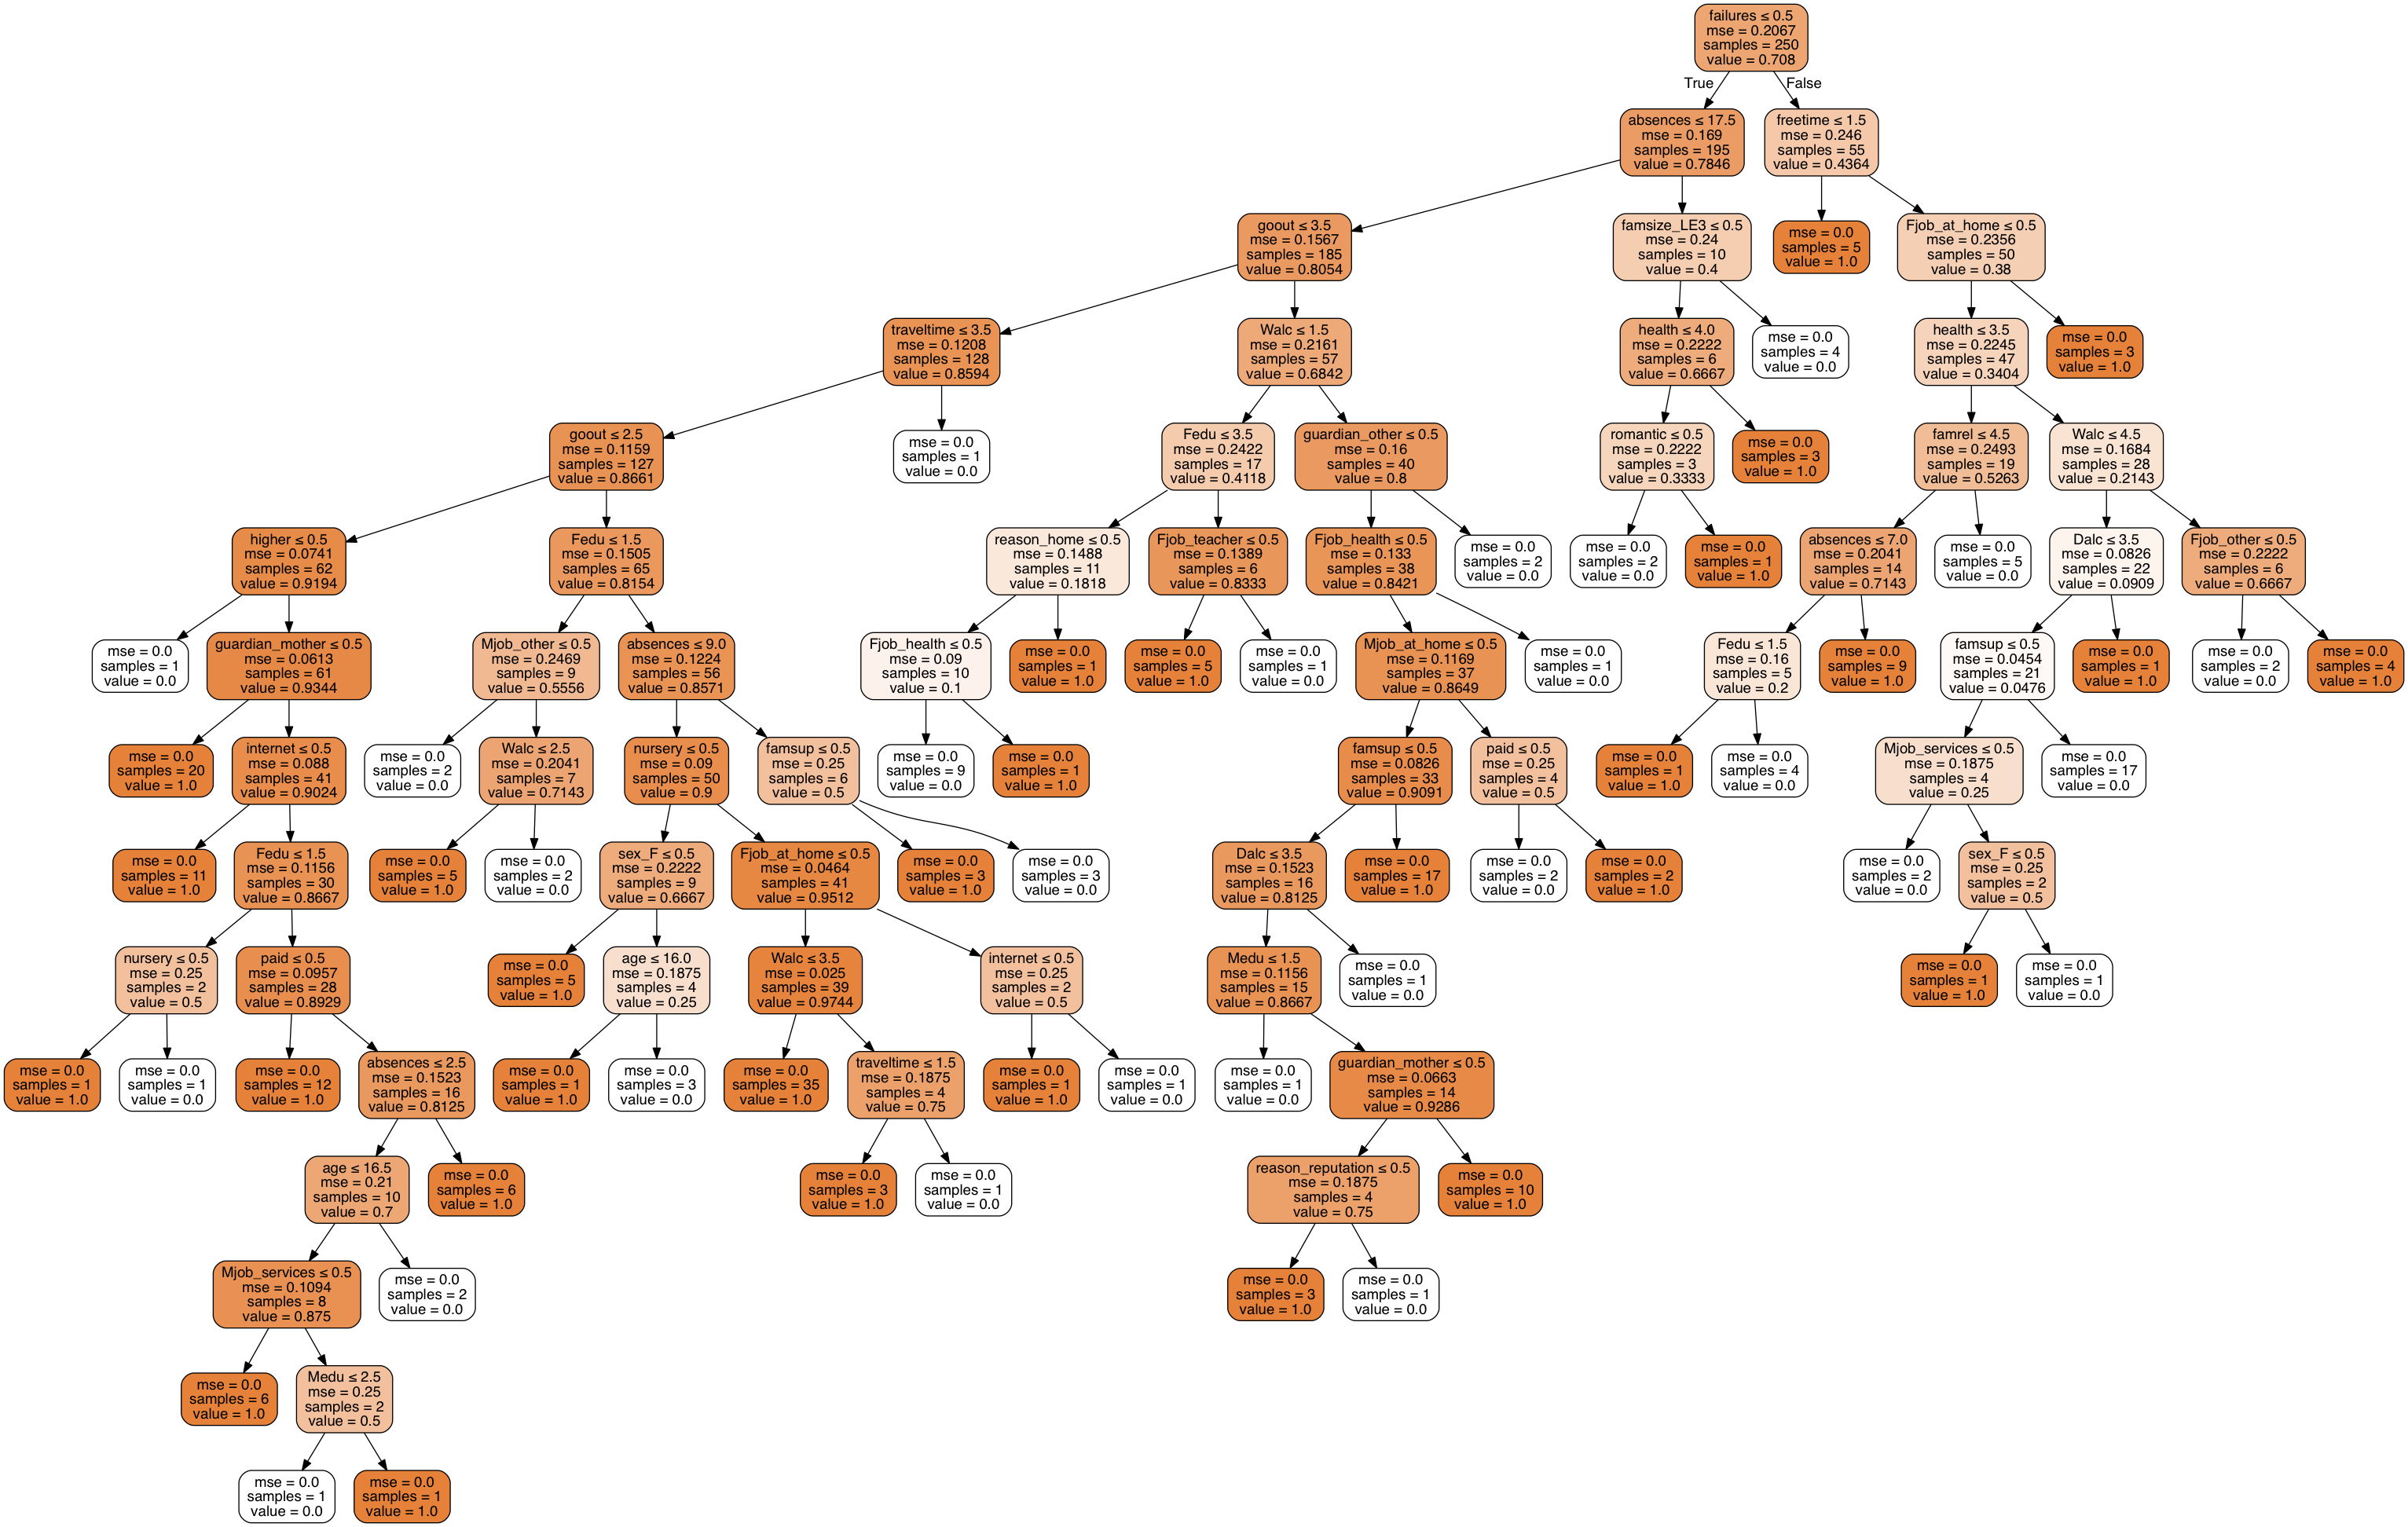

In [220]:
# trying to get the cool graph that is found here: 
# http://scikit-learn.org/stable/modules/tree.html#complexity
from IPython.display import Image
from sklearn.externals.six import StringIO 
from sklearn import tree
#
import pydotplus 

dot_data = StringIO()  
tree.export_graphviz(decision_tree_clf_default, out_file=dot_data,  
                         feature_names=X_all_new.columns,  
                         class_names=['success', 'fail'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [239]:
# exploring SVC a little more!
for c in [0.5,1,5,10]:
    for degree in [1,3,5]:
        print('C', c, ' degree:', degree)
        run_analysis(svm.SVC(C=c, degree=degree))

C 0.5  degree: 1
C 0.5  degree: 3
C 0.5  degree: 5
C 1  degree: 1
C 1  degree: 3
C 1  degree: 5
C 5  degree: 1
C 5  degree: 3
C 5  degree: 5
C 10  degree: 1
C 10  degree: 3
C 10  degree: 5
